# Test Var(N, m) Relation

In [1]:
from reduction import *
data_maps = {1: image_reduction(1), 2: image_reduction(2)}

In [2]:
from stack import *
inst = 1
filt_order = 3
ifield = 6
sample_type = 'jack_region'
dx = 1200
unmask=True

cbmap, psmap, strmask, strnum, mask_inst1, mask_inst2 = \
load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                    (inst,ifield,'psmap'),
                                   (inst,ifield,'strmask'), 
                                   (inst,ifield,'strnum'),
                                  (1,ifield,'mask_inst'),
                                   (2,ifield,'mask_inst')])
if inst==1:
    mask_inst = mask_inst1
else:
    mask_inst = mask_inst2

cbmap = image_poly_filter(cbmap, strmask*mask_inst, degree=filt_order)

In [93]:
Nsub = 16
# Nsigdata = {}
for im in range(4):
    Nsigdata[im] = {}
    
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]

    stacking_class = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                        load_from_file=True, BGsub=False, subsub=True)
    stackdat = stacking_class.stackdat
    cliplim = stacking_class._stackihl_PS_cliplim()

    srctype = 's'
    srcdat = ps_src_select(inst, ifield, m_min, m_max,
        [mask_inst1, mask_inst2], sample_type=sample_type, Nsub=Nsub)

    # start stacking
    rbinedges = stackdat['rbinedges']/0.7 # subpix unit
    rsubbinedges = stackdat['rsubbinedges']/0.7 # subpix unit

    Ilist_dict = {}
    Ilist_dict['Nsrc'] = np.zeros(Nsub)
    start_time = time.time()
    for isub in range(srcdat['Nsub']):
        stackdat['sub'][isub] = {}

        xls = srcdat['sub'][isub]['x' + srctype + '_arr']
        yls = srcdat['sub'][isub]['y' + srctype + '_arr']

        ms = srcdat['sub'][isub]['m' + srctype + '_arr']
        rs = get_mask_radius_th(ifield, ms) # arcsec

        print('stacking %s %d < m < %d, #%d subsample, %d sources, t = %.2f min'\
          %(fieldnamedict[ifield], m_min, m_max,isub,\
           len(xls), (time.time()-start_time)/60))

        Ilist_dict[isub] = []
        for i,(xl,yl,r) in enumerate(zip(xls,yls,rs)):
            cbmapi = cbmap*strmask*mask_inst
            psmapi = psmap*strmask*mask_inst
            maski = strmask*mask_inst
            radmap = make_radius_map(cbmap, xl,yl) # large pix units
            sp1 = np.where((radmap < r/7) & (strnum==1) & (mask_inst==1))
            cbmapi[sp1] = cbmap[sp1]
            psmapi[sp1] = psmap[sp1]
            unmaskpix = np.zeros_like(strmask)
            unmaskpix[sp1] = 1
            maski[sp1] = 1
            if len(sp1[0])>0 and unmask:
                for ibin in [0]:
                    if cliplim['CBmax'][ibin] == np.inf:
                        continue
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (cbmap > cliplim['CBmax'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (cbmap < cliplim['CBmin'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (psmap > cliplim['PSmax'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (psmap < cliplim['PSmin'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0


            # unmask source
            mcb = cbmapi * maski
            mps = psmapi * maski
            xl, yl = int(np.round(xl)), int(np.round(yl))

            if maski[xl,yl]==1:
                Ilist_dict[isub].append(mcb[xl,yl])

        Ilist_dict['Nsrc'][isub] = len(Ilist_dict[isub])

    Nmin = np.min(Ilist_dict['Nsrc'])
    Nsrc_jk_arr = np.arange(Nmin).astype(int)+1
    sigma_arr = np.zeros(len(Nsrc_jk_arr))
    for iNsrc, Nsrc_jk in enumerate(Nsrc_jk_arr):
        Ijk = []
        for isub in range(Nsub):
            Ijk.append(np.mean(Ilist_dict[isub][:Nsrc_jk]))
        sigma_arr[iNsrc] = np.std(Ijk)
        
    Nsigdata[im] = {}
    Nsigdata[im]['N_arr'+srctype] = Nsrc_jk_arr*Nsub
    Nsigdata[im]['sig_arr'+srctype] = sigma_arr
clear_output()

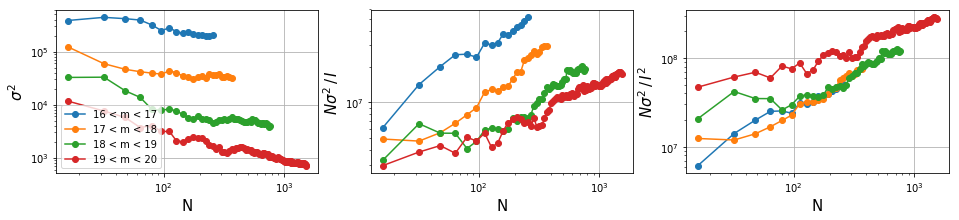

In [120]:
fig, ax = plt.subplots(1, 3, figsize = (16,3))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    N_arr = Nsigdata[im]['N_arr'+srctype]
    sig_arr = Nsigdata[im]['sig_arr'+srctype]
    I = 10**(-im/2.5)
    ax[0].loglog(N_arr, sig_arr**2,'o-', label='%d < m < %d'%(m_min, m_max))
    ax[1].loglog(N_arr, N_arr*sig_arr**2/I,'o-', label='%d < m < %d'%(m_min, m_max))
    ax[2].loglog(N_arr, N_arr*sig_arr**2/I**2,'o-', label='%d < m < %d'%(m_min, m_max))
ax[0].legend()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].set_xlabel('N',fontsize=15)
ax[1].set_xlabel('N',fontsize=15)
ax[2].set_xlabel('N',fontsize=15)
ax[0].set_ylabel(r'$\sigma^2$',fontsize=15)
ax[1].set_ylabel(r'$N\sigma^2\,/\,I$',fontsize=15)
ax[2].set_ylabel(r'$N\sigma^2\,/\,I^2$',fontsize=15)
plt.savefig('/Users/ytcheng/Desktop/cov_scale.png', dpi = 150,bbox_inches='tight')

In [1]:
from run_fit import *

inst = 1
ifield = 4
im = 3
filt_order = filt_order_dict[inst]
subsub = False

param_fit = fit_stacking_mcmc(inst, ifield, im, filt_order, subsub=subsub)

In [2]:
sampler = param_fit.run_mcmc(nwalkers=10, steps=50, return_sampler=True, save_chain=False)

Pre-computing model profiles for interpolation...


100%|██████████| 50/50 [02:44<00:00,  3.28s/it]


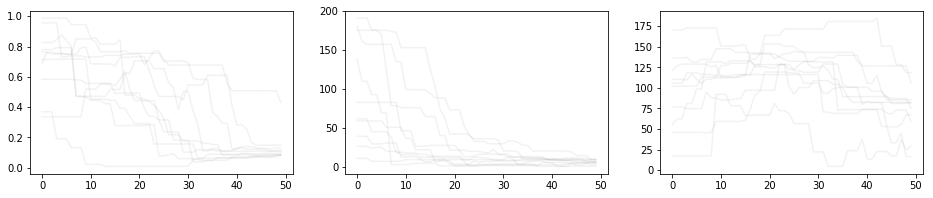

In [10]:
flatsamps = sampler.get_chain()
Npar = flatsamps.shape[-1]
fig, ax = plt.subplots(1, 3, figsize = (16,3))
for i in range(flatsamps.shape[1]):
    ax[0].plot(flatsamps[:,i,0], c='grey', alpha=0.1)
    if Npar==3:
        ax[1].plot(flatsamps[:,i,1], c='grey', alpha=0.1)
        ax[2].plot(flatsamps[:,i,2], c='grey', alpha=0.1)
    else:
        ax[2].plot(flatsamps[:,i,1], c='grey', alpha=0.1)
        ax[1].axis('off')

In [13]:
for xe2 in np.logspace(np.log10(0.0001),np.log10(1),7):
    modelprof = param_fit.get_profexcess_model(xe2=0.05, A1h=1, A2h=1)
    modelprof1 = param_fit.get_profexcess_model(xe2=0.05, A1h=1, A2h=1, fast=True)
    print(modelprof['profgal_sub']/modelprof1['profgal_sub'])

[0.99999998 1.         1.00000003 1.00000008 1.00000021 1.00000046
 1.00000037 0.9999989  0.99999532 1.00000195 1.00000573 0.99998506
 1.00003768 1.00007994 1.00012913]
[0.99999998 1.         1.00000003 1.00000008 1.00000021 1.00000046
 1.00000037 0.9999989  0.99999532 1.00000195 1.00000573 0.99998506
 1.00003768 1.00007994 1.00012913]
[0.99999998 1.         1.00000003 1.00000008 1.00000021 1.00000046
 1.00000037 0.9999989  0.99999532 1.00000195 1.00000573 0.99998506
 1.00003768 1.00007994 1.00012913]
[0.99999998 1.         1.00000003 1.00000008 1.00000021 1.00000046
 1.00000037 0.9999989  0.99999532 1.00000195 1.00000573 0.99998506
 1.00003768 1.00007994 1.00012913]
[0.99999998 1.         1.00000003 1.00000008 1.00000021 1.00000046
 1.00000037 0.9999989  0.99999532 1.00000195 1.00000573 0.99998506
 1.00003768 1.00007994 1.00012913]
[0.99999998 1.         1.00000003 1.00000008 1.00000021 1.00000046
 1.00000037 0.9999989  0.99999532 1.00000195 1.00000573 0.99998506
 1.00003768 1.0000799

In [102]:
for xe2 in np.logspace(np.log10(0.0001),np.log10(1),7):
    profgali = 10**np.array([interpolate.splev([xe2], tck)[0]\
                             for tck in tcks])
    profgali[0] = 1
    profgal_subi = 10**np.array([interpolate.splev([xe2], tck)[0] for tck in tcks_sub])
#     profgal, profgal_sub = param_fit.get_profgal_model(return_all=True, xe2=xe2)
    print(profgal/profgali)
    print(profgal_sub/profgal_subi)

[  1.           1.01013166   1.03897321   1.08018657   1.13542963
   1.24152921   1.4762925    2.05319821   3.75840689   9.65019273
  30.67005331  73.08709478 145.96193836 272.07274751 475.65120371
 607.156065   165.8588101   15.33442729  11.27040151  10.09717109
   9.58126546   9.32648202   9.15950197   8.97323538   8.4800011 ]
[  1.14346175   1.4762925    2.05319821   3.75840689   9.65019273
  30.67005331  73.08709478 145.96193836 272.07274751 475.65120371
 607.156065   165.8588101   15.33442729  11.27040151   9.71556511]
[  1.           1.0101307    1.0389694    1.08018122   1.13542319
   1.24151999   1.47627574   2.0531598    3.75829      9.649786
  30.66883025  73.08536265 145.95903774 272.06669036 475.64099036
 607.15005356 165.86265027  15.33380063  11.27124598  10.09323893
   9.57511429   9.31673653   9.16390626   9.02501622   8.31786829]
[  1.14345545   1.47627574   2.0531598    3.75829      9.649786
  30.66883025  73.08536265 145.95903774 272.06669036 475.64099036
 607.150053

In [40]:
from scipy import interpolate

tck = interpolate.splrep(xe2_arr, profgal_arr[:,0])


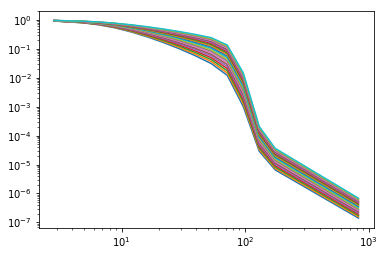

In [11]:




for i in range(profgal_arr.shape[0]):
#     plt.loglog(param_fit.rbins, profgal_arr[i])
    plt.loglog(param_fit.rsubbins, profgal_sub_arr[i])

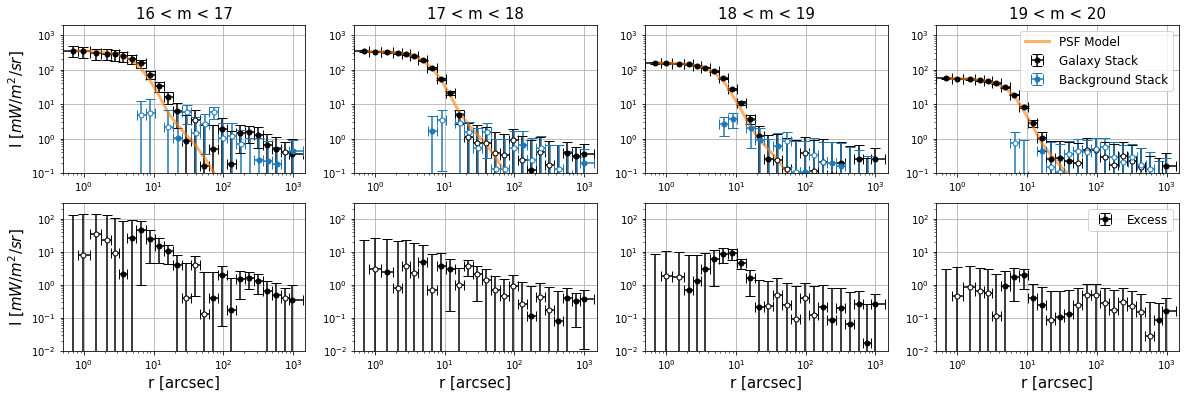

In [444]:
from stack import *

for ifield in [5]:
    for inst in [2]:
        plt.close()
        fig, ax = plt.subplots(2, 4, figsize = (20,6))
        filt_order = filt_order_dict[inst]
        for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
            subsub = True if im==0 else False
            stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                                load_from_file=True, BGsub=False, subusb=subsub).stackdat

            plot_err_log(stackdat['rsubbins'], 
                         stackdat['profcbsub'],
                         np.sqrt(np.diag(stackdat['cov']['profcb'])),
                         ax=ax[0][im], color='k',label='Galaxy Stack')
            ax[0][im].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
                          'C1', alpha=0.6, lw=3, label='PSF Model')
            plot_err_log(stackdat['rbins']*1.01, 
                         stackdat['BG']['profcb'],
                         np.sqrt(np.diag(stackdat['BGcov']['profcb'])),
                         ax=ax[0][im], color='C0', label='Background Stack')
            ax[0][im].set_ylim([1e-1,2e3])
            ax[0][im].set_xlim([5e-1,1.5e3])
            ax[0][im].grid()    
            ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)

            plot_err_log(stackdat['rbins'], 
                         stackdat['ex']['profcb'],
                         np.sqrt(np.diag(stackdat['excov']['profcb'])),
                         ax=ax[1][im], color='k',label='Excess')
            ax[1][im].set_ylim([1e-2,3e2])
            ax[1][im].set_xlim([5e-1,1.5e3])
            ax[1][im].grid()    
            ax[1][im].set_xlabel('r [arcsec]', fontsize=15)

        ax[0][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
        ax[1][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
        ax[0][-1].legend(fontsize=12)
        ax[1][-1].legend(fontsize=12)

#         plt.savefig('plots/paperfig/profile_TM%d_%s.pdf'%(inst, fieldnamedict[ifield]),
#                     dpi = 150, bbox_inches='tight')

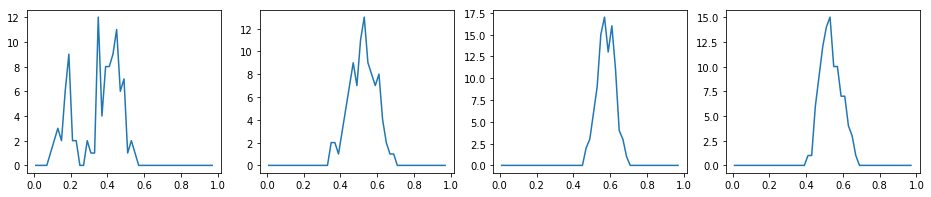

In [169]:
from utils import *
inst = 1
Npar = 3

fig, ax = plt.subplots(1,4,figsize=(16,3))
for ifield in [5]:#[None, 4,5,6,7,8]:
    for im in range(4):
        chains = get_mcmc_chains(inst, im, ifield, Npar=Npar, burn_in = 150)
        burn_in = 150
        ch_acc = chains[burn_in:,:,0]
        acc_rate = np.array([np.sum(ch_acc[1:,i]!=ch_acc[:-1,i])/(ch_acc.shape[0]-1) \
                    for i in range(ch_acc.shape[1])])
        binedges = np.arange(0,1,0.02)
        bins = (binedges[1:] + binedges[:-1]) / 2
        h,_ = np.histogram(acc_rate, bins = binedges)
        ax[im].plot(bins, h)

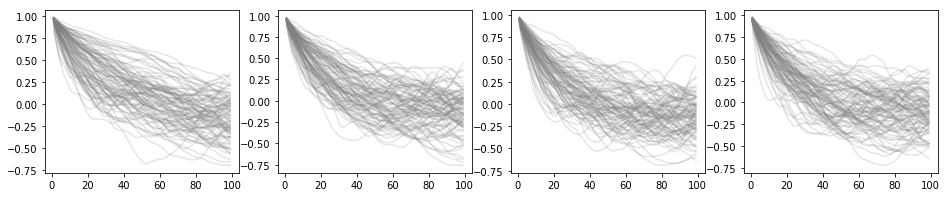

In [171]:
import pymc3 as pm3

inst = 1
Npar = 3
ifield = 5
im = 0
burn_in = 150
lags=np.arange(1,100)
fig, ax = plt.subplots(1,4,figsize=(16,3))
for im in range(4):
    chains = get_mcmc_chains(inst, im, ifield, Npar=Npar, burn_in=burn_in)
    for i in range(100):
        autocorr = [pm3.autocorr(chains[:,i,0], l) for l in lags]
        ax[im].plot(lags, autocorr, c='grey',alpha=0.2)